In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [37]:
!pip install tensorflow-datasets

####  Load the dataset (TF Flowers)

In [38]:
import tensorflow_datasets as tfds
(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [39]:
label_names = ds_info.features['label'].names

#### Count label distribution

In [40]:
label_counts = {label: 0 for label in range(len(label_names))}
for _, label in tfds.as_numpy(ds_train):
    label_counts[label] += 1

#### Plot label distribution

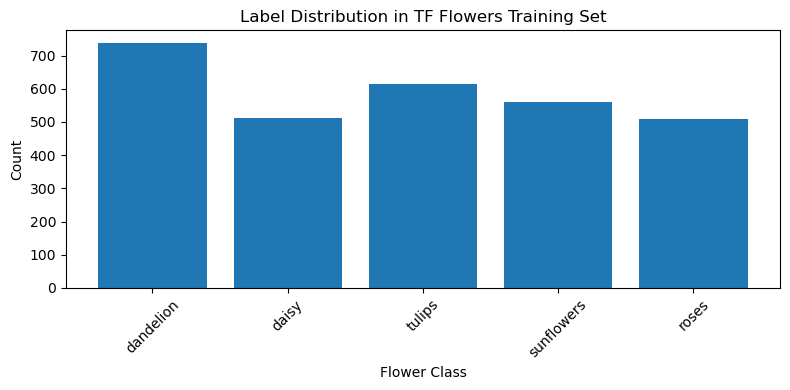

In [41]:
plt.figure(figsize=(8, 4))
plt.bar([label_names[i] for i in label_counts.keys()], label_counts.values())
plt.title("Label Distribution in TF Flowers Training Set")
plt.xlabel("Flower Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Display sample images from each class

In [42]:
samples_per_class = {label: None for label in range(len(label_names))}
for image, label in ds_train:
    label = int(label.numpy())
    if samples_per_class[label] is None:
        samples_per_class[label] = image
    if all(v is not None for v in samples_per_class.values()):
        break

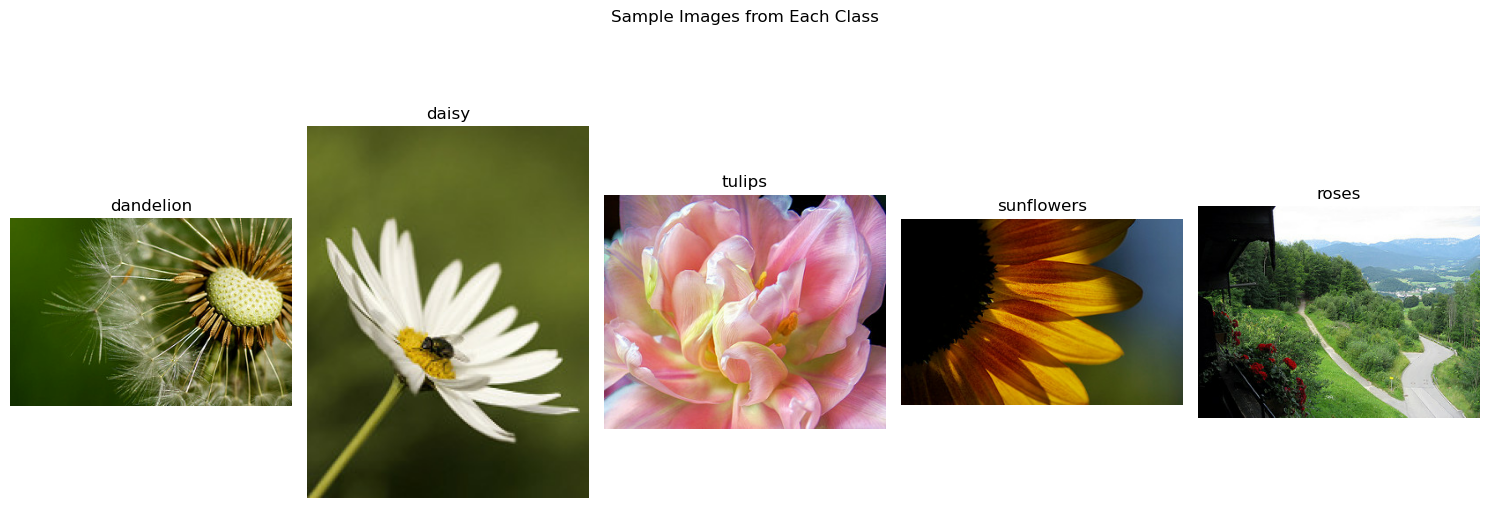

In [43]:
plt.figure(figsize=(15, 6))
for idx, (label, image) in enumerate(samples_per_class.items()):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label_names[label])
    plt.axis("off")
plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()


#### Preprocessing

In [44]:
IMG_SIZE = (224, 224)

In [45]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

In [46]:
BATCH_SIZE = 32
train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Load NASNetMobile

In [47]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


#### Add custom head

In [48]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(ds_info.features['label'].num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#### Compile the model

In [49]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Train

In [50]:

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 612ms/step - accuracy: 0.5250 - loss: 1.1857 - val_accuracy: 0.7766 - val_loss: 0.6361
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.8195 - loss: 0.5686 - val_accuracy: 0.8174 - val_loss: 0.4989
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 525ms/step - accuracy: 0.8471 - loss: 0.4498 - val_accuracy: 0.8406 - val_loss: 0.4433
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 523ms/step - accuracy: 0.8777 - loss: 0.3850 - val_accuracy: 0.8515 - val_loss: 0.4101
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 529ms/step - accuracy: 0.8976 - loss: 0.3406 - val_accuracy: 0.8556 - val_loss: 0.3881
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9098 - loss: 0.3077 - val_accuracy: 0.8583 - val_loss: 0.3729
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 516ms/step - accuracy: 0.9171 - loss: 0.2811 - val_accuracy: 0.8610 - val_loss: 0.3615
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 525ms/step - accuracy: 0.9232 - loss: 0.2588 - val_accura

 #### Visualize training

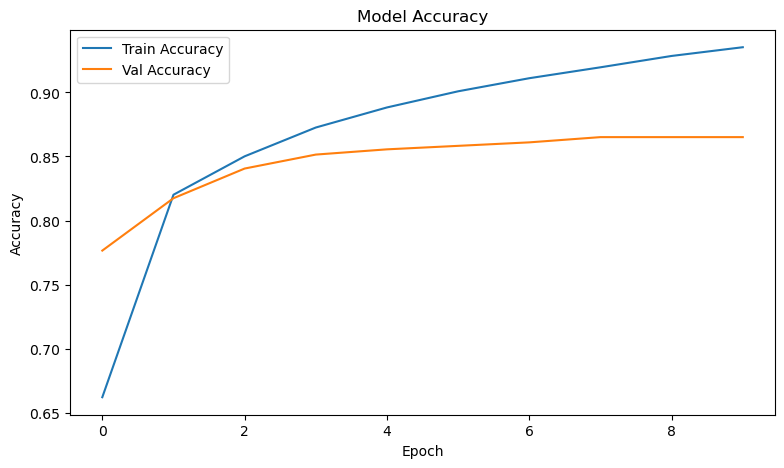

In [51]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

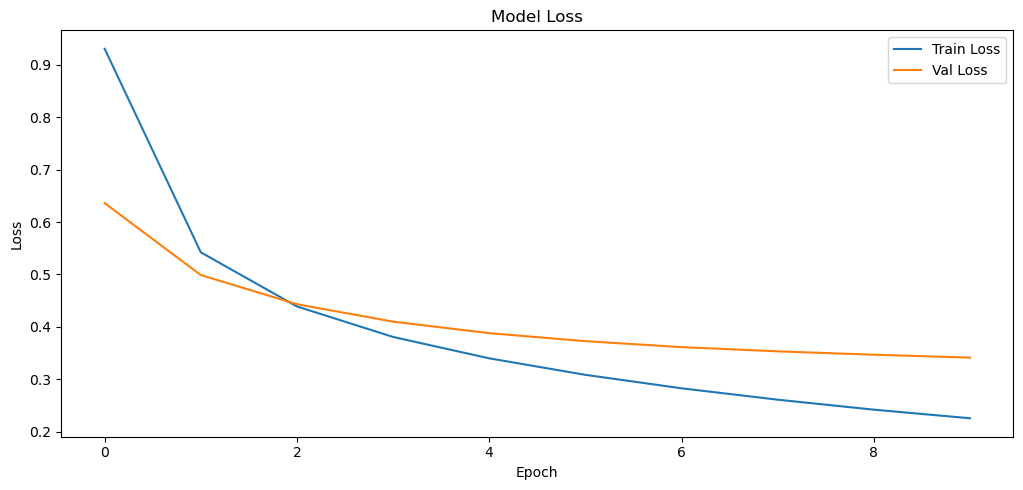

In [52]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
